https://pypi.org/project/LLMGraphTransformer/

In [4]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_ollama import ChatOllama
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.prompts import ChatPromptTemplate
import os

In [5]:
retriever = WikipediaRetriever()
docs = retriever.invoke("Apollo 11")
text = docs[0].page_content
print(text)

Apollo 11 (July 16–24, 1969) was the fifth manned flight in the United States Apollo program and the first spaceflight to land humans on the Moon. Commander Neil Armstrong and Lunar Module Pilot Edwin "Buzz" Aldrin landed the Lunar Module Eagle on July 20 at 20:17 UTC, and Armstrong became the first person to step onto the surface about six hours later, at 02:56 UTC on July 21. Aldrin joined him 19 minutes afterward, and together they spent about two and a half hours exploring the site they had named Tranquility Base upon landing. They collected 47.5 pounds (21.5 kg) of lunar material before re-entering the Lunar Module. In total, they were on the Moon’s surface for 21 hours, 36 minutes before returning to the Command Module Columbia, which remained in lunar orbit, piloted by Michael Collins.
Apollo 11 was launched by a Saturn V rocket from Kennedy Space Center in Florida, on July 16 at 13:32 UTC (9:32 am EDT, local time). The Apollo spacecraft consisted of three parts: the command mod

/home/maximos/anaconda3/envs/ollama/lib/python3.12/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/maximos/anaconda3/envs/ollama/lib/python3.12/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [6]:
# Initialize the ChatOllama model with the specified model name
# model_name = 'qwen3-vl:4b'
model_name = 'llama3.2:3b'  # Or another text-focused model

# and initialize the ChatOllama instance
chat_model = ChatOllama(
    model=model_name,
    validate_model_on_init=True,
    temperature=0
)

In [7]:
# Create a ChatPromptTemplate for graph extraction
graph_extraction_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert at extracting entities and relationships from text to build knowledge graphs.
Focus on extracting as many useful named entities and relations as you can to make the graph complete and accurate.
Try to include all persons and their roles, locations, organizations, and significant events mentioned in the text.

Key guidelines:
- Extract only named entities (people, places, organizations, events) using their exact names as they appear in the text. Do not use placeholders, generics, or abstracts like 'Node1', 'Person A', or 'Event X'.
- For relationships, use clear, descriptive types based on the text (e.g., 'LEADER_OF', 'PART_OF').
- Retain relevant attributes if mentioned, but prioritize concrete, text-based names.
- Ensure the graph reflects the story accurately without inventing or generalizing entities.
- Try to include information about the roles, especially for people mentioned in the text.
"""),
    ("human", "{input}")
])

In [8]:
no_schema = LLMGraphTransformer(
    llm=chat_model,
    prompt=graph_extraction_prompt,
)

In [9]:
# with open('Sherlock/scan.txt', 'r') as file:
#     text = file.read().replace('\n', '')
# print(text)

In [14]:
text = """
Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris.
Also, Robin Williams.
"""

In [15]:
documents = [Document(page_content=text)]

In [16]:
print(documents)

[Document(metadata={}, page_content='\nMarie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\nShe was, in 1906, the first woman to become a professor at the University of Paris.\nAlso, Robin Williams.\n')]


In [17]:
graph_no_schema = no_schema.convert_to_graph_documents(documents)

In [18]:
print(graph_no_schema)
print(f"Nodes: {graph_no_schema[0].nodes}")
print(f"Relationships: {graph_no_schema[0].relationships}")

[GraphDocument(nodes=[Node(id='Marie Curie', type='Person', properties={}), Node(id='Pierre Curie', type='Person', properties={}), Node(id='Robin Williams', type='Person', properties={}), Node(id='University Of Paris', type='Organization', properties={})], relationships=[Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='Pierre Curie', type='Person', properties={}), type='MARRIAGE_OF', properties={}), Relationship(source=Node(id='Marie Curie', type='Person', properties={}), target=Node(id='University Of Paris', type='Organization', properties={}), type='EMPLOYMENT_OF', properties={}), Relationship(source=Node(id='Robin Williams', type='Person', properties={}), target=Node(id='Marie Curie', type='Person', properties={}), type='MENTIONED_BY', properties={})], source=Document(metadata={}, page_content='\nMarie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioacti

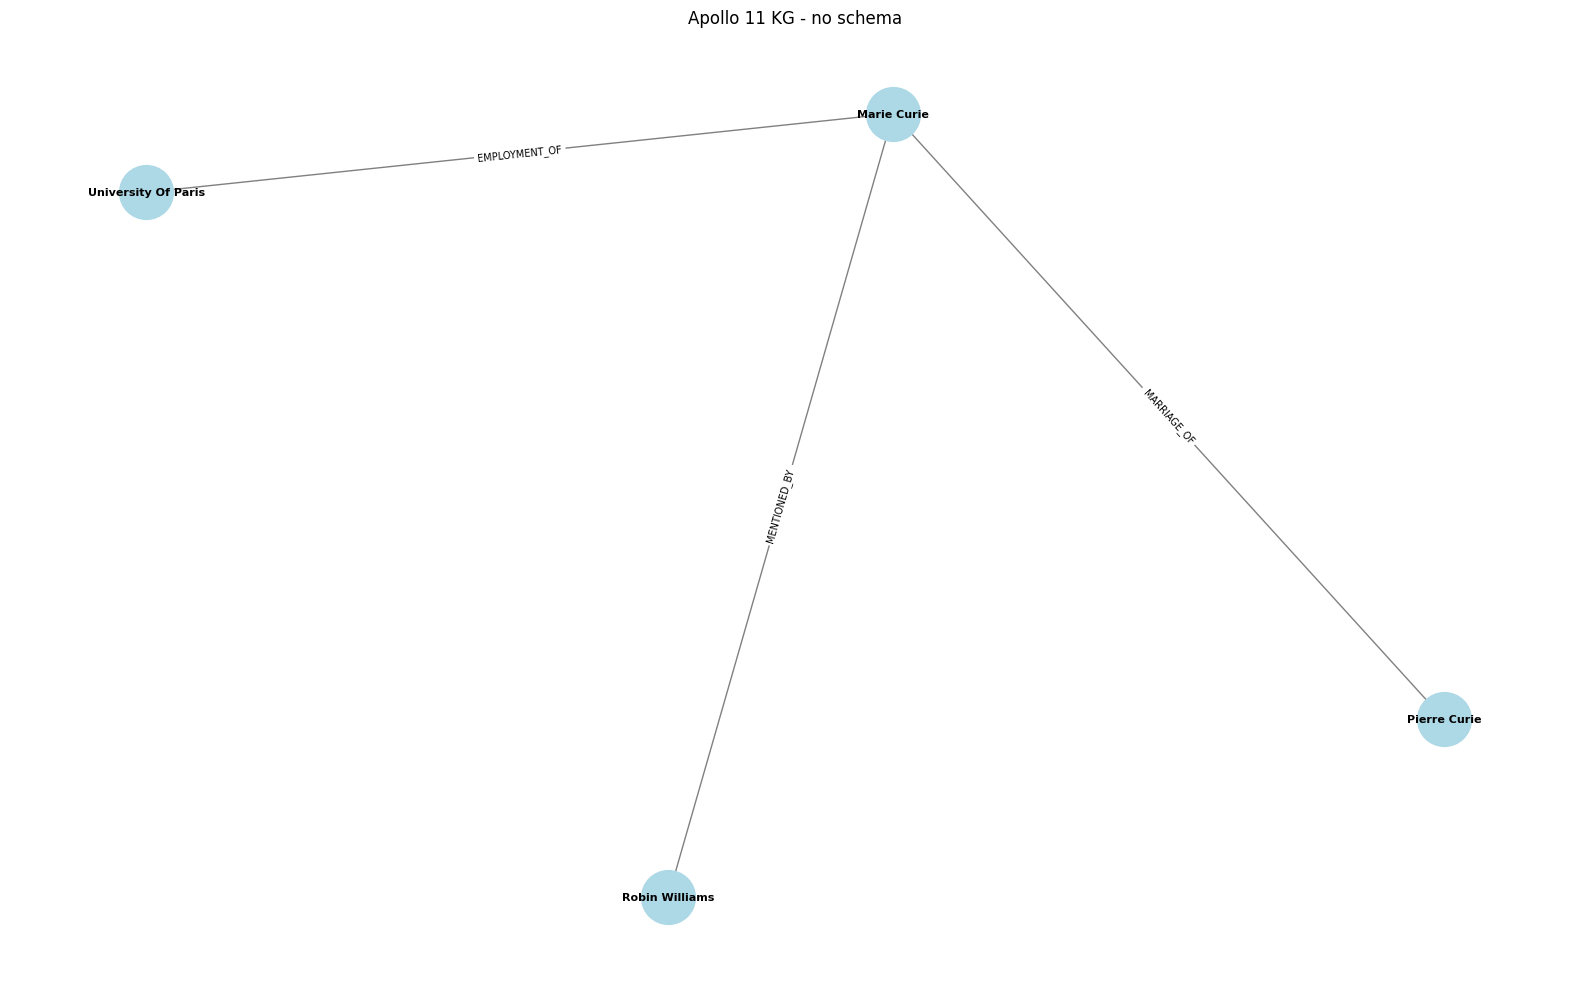

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert graph documents to NetworkX graph
G = nx.DiGraph()

for doc in graph_no_schema:
    for node in doc.nodes:
        G.add_node(node.id, label=node.type)
    for rel in doc.relationships:
        G.add_edge(rel.source.id, rel.target.id, label=rel.type)

# Get connected components (treating as undirected to find connected parts)
G_undirected = G.to_undirected()
components = list(nx.connected_components(G_undirected))

# Position each component separately
pos = {}
x_offset = 0
for component in components:
    # Create subgraph for this component
    subgraph = G.subgraph(component)
    # Layout this component
    component_pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
    
    # Shift component positions to avoid overlap
    for node, (x, y) in component_pos.items():
        pos[node] = (x + x_offset, y)
    
    # Offset for next component
    x_offset += 3

# Visualize as static image
plt.figure(figsize=(16, 10))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)

os.makedirs('figs', exist_ok=True)

plt.title("Apollo 11 KG - no schema")
plt.axis('off')
plt.tight_layout()
plt.savefig('figs/apollo_graph_no_schema.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
from pyvis.network import Network

# Create Pyvis network
net = Network(directed=True, notebook=True, height="750px", width="100%")

# Add nodes and edges from graph documents
for doc in graph_no_schema:
    for node in doc.nodes:
        net.add_node(node.id, label=node.id, title=f"Type: {node.type}")
    for rel in doc.relationships:
        # Ensure source and target nodes exist
        if not net.get_node(rel.source.id):
            net.add_node(rel.source.id, label=rel.source.id, title="Inferred Node")
        if not net.get_node(rel.target.id):
            net.add_node(rel.target.id, label=rel.target.id, title="Inferred Node")
        net.add_edge(
            rel.source.id,
            rel.target.id,
            label=rel.type
        )

os.makedirs('html', exist_ok=True)

# Customize physics
net.show_buttons(filter_=['physics'])
net.save_graph('html/apollo_graph_no_schema.html')

In [19]:
allowed_node_types = [
    "Person",
    "Organization",
    "Location",
    "Country",
    "Event",
    "State",
    "Vehicle",
    "Date"
]

allowed_relationship_types = [
    "LEADER_OF",
    "MEMBER_OF",
    "CAPTAIN_OF",
    "CONTROLLED_BY",
    "PART_OF",
    "BORN_IN",
    "FOUNDED_IN",
    "HAPPENED_ON"
]

additional_instructions = "Keep only surnames for persons where appropriate."

In [20]:
with_schema = LLMGraphTransformer(
    llm=chat_model,
    prompt=graph_extraction_prompt,
    allowed_nodes=allowed_node_types,
    allowed_relationships=allowed_relationship_types,
    additional_instructions=additional_instructions
)

In [21]:
graph_with_schema = with_schema.convert_to_graph_documents(documents)

In [22]:
print(graph_no_schema)
print(f"Nodes: {graph_no_schema[0].nodes}")
print(f"Relationships: {graph_no_schema[0].relationships}")

[GraphDocument(nodes=[Node(id='Apollo 11', type='Mission', properties={}), Node(id='Neil Armstrong', type='Person', properties={}), Node(id="Edwin 'Buzz' Aldrin", type='Person', properties={}), Node(id='Lunar Module Eagle', type='Vehicle', properties={}), Node(id='Commander Neil Armstrong', type='Role', properties={}), Node(id="Lunar Module Pilot Edwin 'Buzz' Aldrin", type='Role', properties={}), Node(id='Tranquility Base', type='Location', properties={}), Node(id='Moon', type='Location', properties={}), Node(id='Kennedy Space Center', type='Location', properties={}), Node(id='Florida', type='Location', properties={}), Node(id='Saturn V Rocket', type='Vehicle', properties={}), Node(id='Command Module Columbia', type='Vehicle', properties={}), Node(id='Service Module Sm', type='Vehicle', properties={}), Node(id='Lunar Module Lm', type='Vehicle', properties={}), Node(id='Descent Stage', type='Component', properties={}), Node(id='Ascent Stage', type='Component', properties={}), Node(id='M

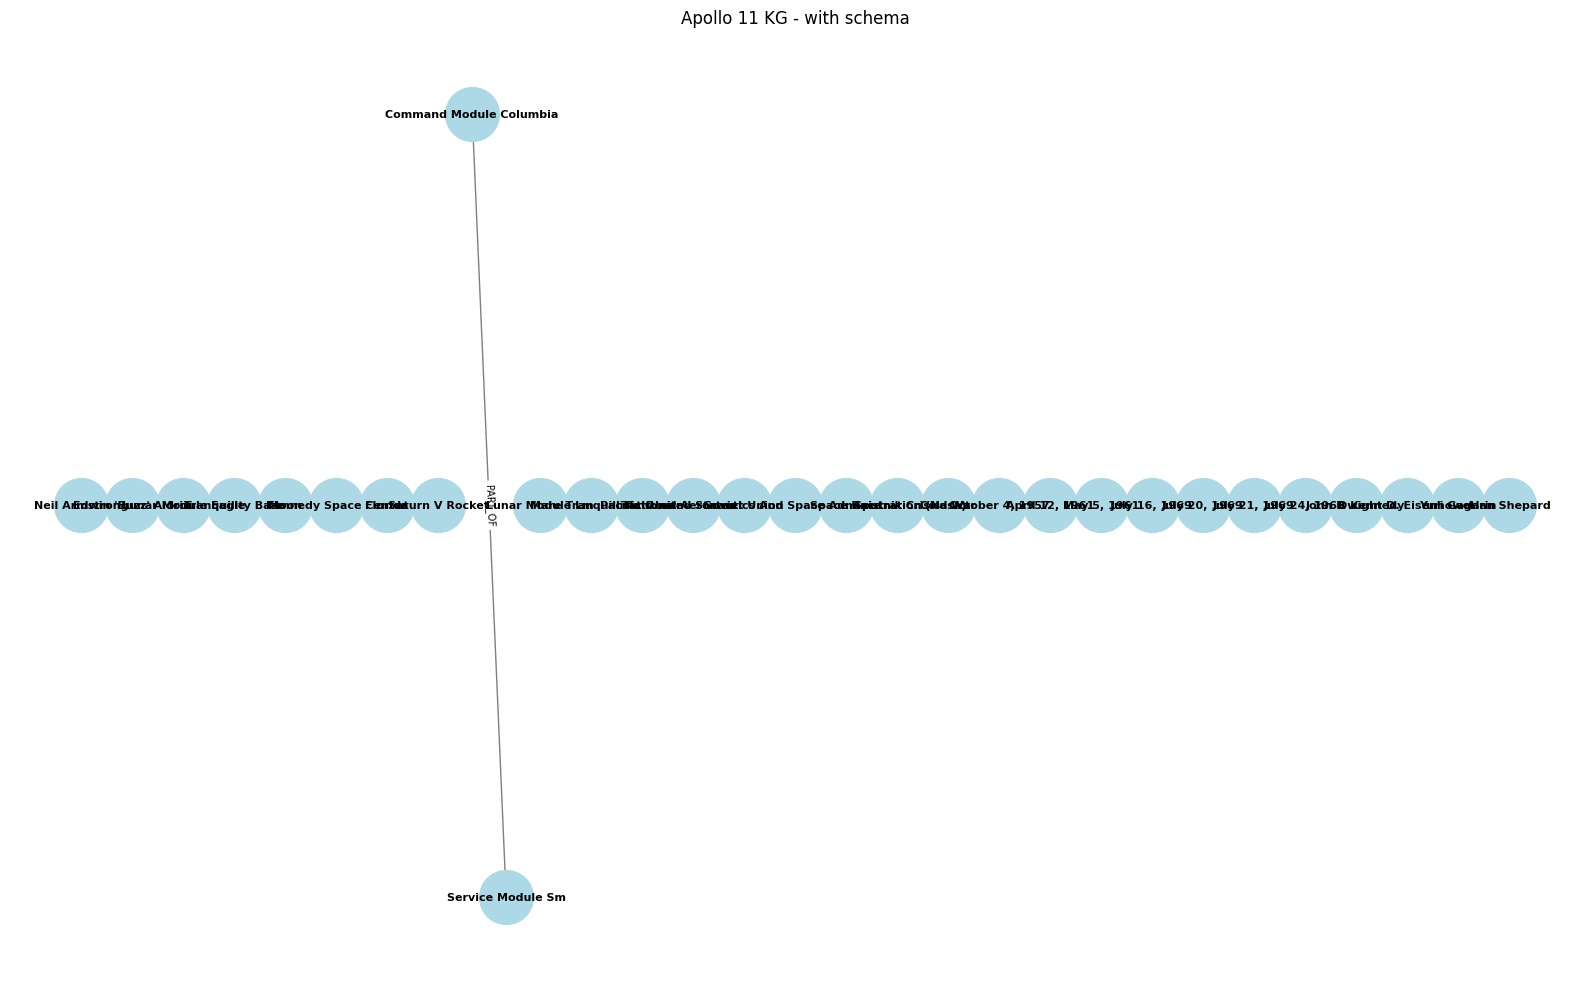

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert graph documents to NetworkX graph
G = nx.DiGraph()

for doc in graph_with_schema:
    for node in doc.nodes:
        G.add_node(node.id, label=node.type)
    for rel in doc.relationships:
        G.add_edge(rel.source.id, rel.target.id, label=rel.type)

# Get connected components (treating as undirected to find connected parts)
G_undirected = G.to_undirected()
components = list(nx.connected_components(G_undirected))

# Position each component separately
pos = {}
x_offset = 0
for component in components:
    # Create subgraph for this component
    subgraph = G.subgraph(component)
    # Layout this component
    component_pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
    
    # Shift component positions to avoid overlap
    for node, (x, y) in component_pos.items():
        pos[node] = (x + x_offset, y)
    
    # Offset for next component
    x_offset += 3

# Visualize as static image
plt.figure(figsize=(16, 10))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)

os.makedirs('figs', exist_ok=True)

plt.title("Apollo 11 KG - with schema")
plt.axis('off')
plt.tight_layout()
plt.savefig('figs/apollo_graph_with_schema.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
from pyvis.network import Network

# Create Pyvis network
net = Network(directed=True, notebook=True, height="750px", width="100%")

# Add nodes and edges from graph documents
for doc in graph_with_schema:
    for node in doc.nodes:
        net.add_node(node.id, label=node.id, title=f"Type: {node.type}")
    for rel in doc.relationships:
        # Ensure source and target nodes exist
        if not net.get_node(rel.source.id):
            net.add_node(rel.source.id, label=rel.source.id, title="Inferred Node")
        if not net.get_node(rel.target.id):
            net.add_node(rel.target.id, label=rel.target.id, title="Inferred Node")
        net.add_edge(
            rel.source.id,
            rel.target.id,
            label=rel.type
        )

os.makedirs('html', exist_ok=True)

# Customize physics
net.show_buttons(filter_=['physics'])
net.save_graph('html/apollo_graph_with_schema.html')